In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
data_dir = "indian_food_classification.ipynb"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

NotADirectoryError: [Errno 20] Not a directory: 'indian_food_classification.ipynb'

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Food Classification.zip to Food Classification (1).zip


In [ ]:
import zipfile

with zipfile.ZipFile('Food Classification (1).zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
import os

for file in os.listdir('data'):
    print(file)


jalebi
samosa
kadai_paneer
dhokla
pizza
paani_puri
chai
chole_bhature
kaathi_rolls
chapati
pav_bhaji
dal_makhani
momos
butter_naan
burger
masala_dosa
pakode
idli
kulfi
fried_rice


In [ ]:
import tensorflow as tf

image_size = (224, 224)  # Resize all images to this size
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)


Found 6269 files belonging to 20 classes.


In [ ]:
class_names = train_dataset.class_names
print("Classes:", class_names)


Classes: ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']


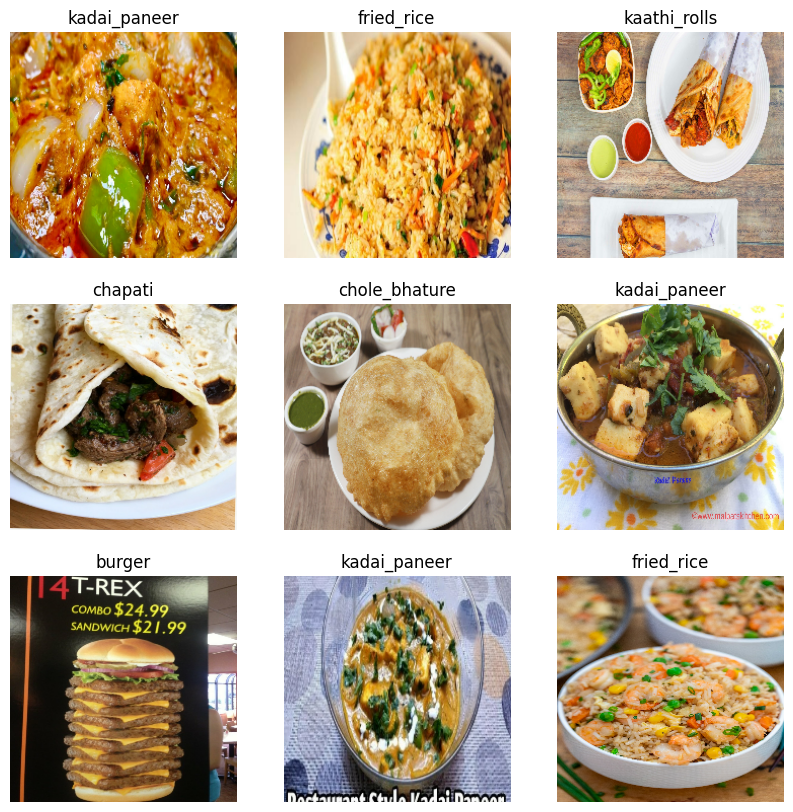

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

# Optional: improve pipeline performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 6269 files belonging to 20 classes.
Using 5016 files for training.
Found 6269 files belonging to 20 classes.
Using 1253 files for validation.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze the pretrained layers


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras import layers, models

num_classes = len(train_ds.class_names)

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),        # Flattening feature maps
    layers.Dense(128, activation='relu'),   # Learn complex patterns
    layers.Dropout(0.3),                    # Prevent overfitting
    layers.Dense(num_classes, activation='softmax')  # Output layer
])


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

In [ ]:
# Load dataset first
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

# ✅ Get class names BEFORE caching/prefetching
class_names = train_ds.class_names
num_classes = len(class_names)

# Now cache/prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 6269 files belonging to 20 classes.
Using 5016 files for training.
Found 6269 files belonging to 20 classes.
Using 1253 files for validation.


In [ ]:
from tensorflow.keras import layers, models

num_classes = len(class_names)  # Use the fixed class_names variable

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])



In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # You can increase this to 10, 15, etc.
)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.1199 - loss: 2.9532 - val_accuracy: 0.2546 - val_loss: 2.5259
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 150s 957ms/step - accuracy: 0.2259 - loss: 2.5302 - val_accuracy: 0.2897 - val_loss: 2.3594
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 149s 951ms/step - accuracy: 0.2668 - loss: 2.3784 - val_accuracy: 0.3168 - val_loss: 2.2934
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.3168 - loss: 2.2462 - val_accuracy: 0.3336 - val_loss: 2.2279
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.3561 - loss: 2.1454 - val_accuracy: 0.3440 - val_loss: 2.1693


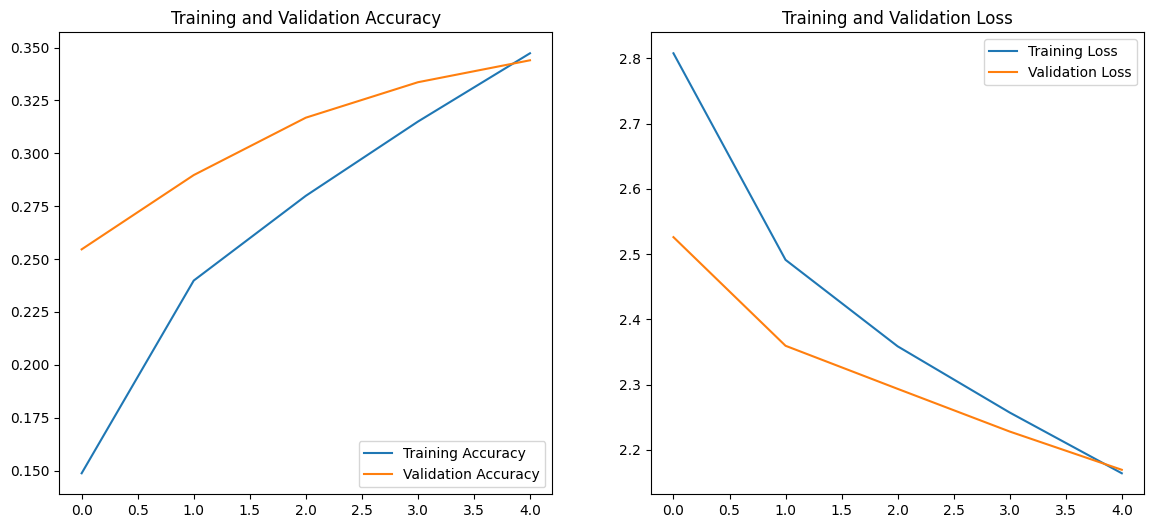

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy:     {final_train_acc:.4f}")
print(f"Final Validation Accuracy:   {final_val_acc:.4f}")
print(f"Final Training Loss:         {final_train_loss:.4f}")
print(f"Final Validation Loss:       {final_val_loss:.4f}")


Final Training Accuracy:     0.3473
Final Validation Accuracy:   0.3440
Final Training Loss:         2.1640
Final Validation Loss:       2.1693


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)


Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.3553 - loss: 2.0900 - val_accuracy: 0.3488 - val_loss: 2.1256
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3819 - loss: 2.0033 - val_accuracy: 0.3583 - val_loss: 2.1069
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3954 - loss: 1.9707 - val_accuracy: 0.3639 - val_loss: 2.0950
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4161 - loss: 1.9172 - val_accuracy: 0.3711 - val_loss: 2.0923
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4386 - loss: 1.8384 - val_accuracy: 0.3631 - val_loss: 2.0779
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.4554 - loss: 1.7769 - val_accuracy: 0.3815 - val_loss: 2.0640
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.4700 - loss: 1.7439 - val_accuracy: 0.3639 - val_loss: 2.0972
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 155s 991ms/step - accuracy: 0.4604 - loss: 1.7360 - val_a

In [ ]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy:     {final_train_acc:.4f}")
print(f"Final Validation Accuracy:   {final_val_acc:.4f}")
print(f"Final Training Loss:         {final_train_loss:.4f}")
print(f"Final Validation Loss:       {final_val_loss:.4f}")


Final Training Accuracy:     0.5498
Final Validation Accuracy:   0.3759
Final Training Loss:         1.4627
Final Validation Loss:       2.1385


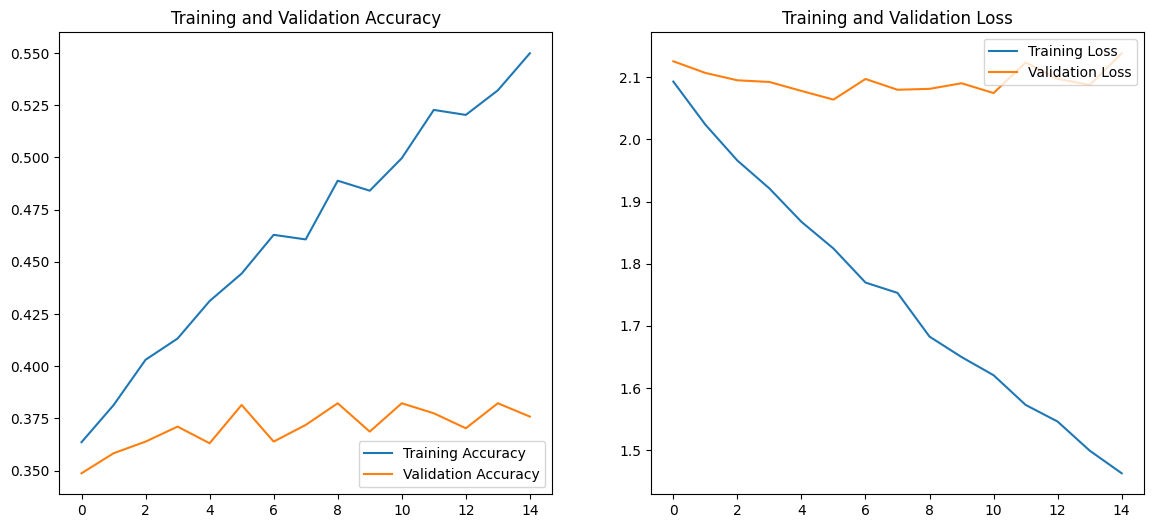

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])


In [ ]:
from tensorflow.keras import layers, models

num_classes = len(class_names)

model = models.Sequential([
    data_augmentation,                   # New layer on top
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.1133 - loss: 2.9888 - val_accuracy: 0.1644 - val_loss: 2.7112
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.2051 - loss: 2.5857 - val_accuracy: 0.2434 - val_loss: 2.5029
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.2389 - loss: 2.4637 - val_accuracy: 0.2506 - val_loss: 2.4924
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.2782 - loss: 2.3736 - val_accuracy: 0.2466 - val_loss: 2.4531
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.2749 - loss: 2.3202 - val_accuracy: 0.2538 - val_loss: 2.4049
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.3185 - loss: 2.2288 - val_accuracy: 0.2682 - val_loss: 2.3878
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.3215 - loss: 2.1963 - val_accuracy: 0.2729 - val_loss: 2.3883
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.3415 - loss: 2.2074 - val_accu

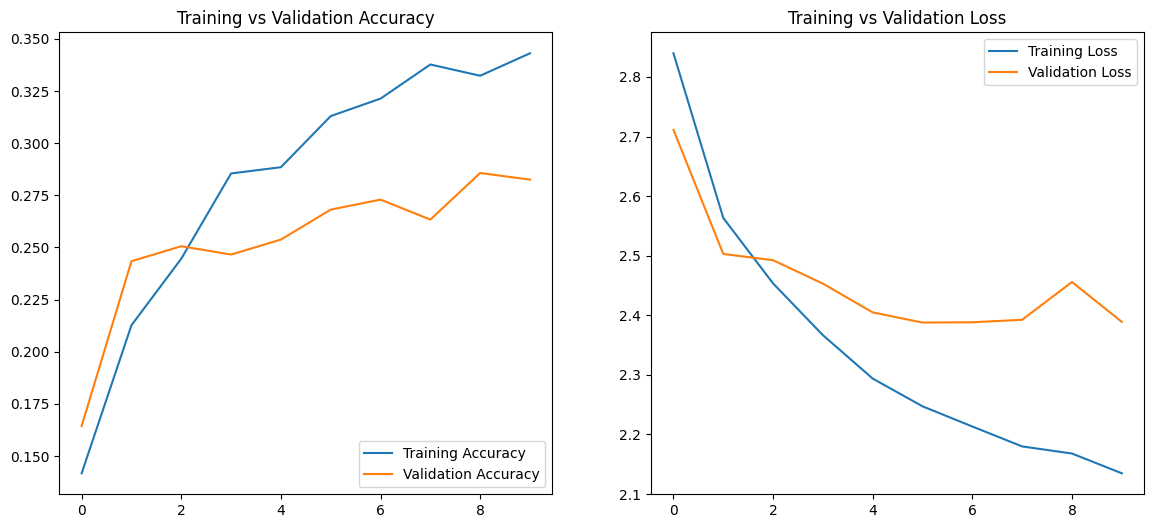

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.show()


In [ ]:
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = loss[-1]
final_val_loss = val_loss[-1]

print(f"Final Training Accuracy:     {final_train_acc:.4f}")
print(f"Final Validation Accuracy:   {final_val_acc:.4f}")
print(f"Final Training Loss:         {final_train_loss:.4f}")
print(f"Final Validation Loss:       {final_val_loss:.4f}")


Final Training Accuracy:     0.3431
Final Validation Accuracy:   0.2825
Final Training Loss:         2.1349
Final Validation Loss:       2.3890


In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [ ]:
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


In [ ]:
base_model.trainable = True

# Optional: freeze very low-level layers
for layer in base_model.layers[:100]:
    layer.trainable = False


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Smaller learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # or 5 to test quicker
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.0573 - loss: 3.1803 - val_accuracy: 0.0527 - val_loss: 3.3672
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.0937 - loss: 2.9692 - val_accuracy: 0.0638 - val_loss: 3.2458
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.1324 - loss: 2.8470 - val_accuracy: 0.0766 - val_loss: 3.1149
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.1576 - loss: 2.7564 - val_accuracy: 0.1141 - val_loss: 2.9643
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.1911 - loss: 2.6646 - val_accuracy: 0.1492 - val_loss: 2.8192
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.2316 - loss: 2.5538 - val_accuracy: 0.1852 - val_loss: 2.6758
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.2788 - loss: 2.4439 - val_accuracy: 0.2203 - val_loss: 2.5672
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.2856 - loss: 2.3973 - val_accu

In [ ]:
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

print(f"Final Training Accuracy:     {acc[-1]:.4f}")
print(f"Final Validation Accuracy:   {val_acc[-1]:.4f}")
print(f"Final Training Loss:         {loss[-1]:.4f}")
print(f"Final Validation Loss:       {val_loss[-1]:.4f}")


Final Training Accuracy:     0.3417
Final Validation Accuracy:   0.3376
Final Training Loss:         2.2205
Final Validation Loss:       2.2876


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_and_show(img_path):
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.show()


In [ ]:
import os

sample_images = os.listdir('data/pizza')  # you can try any class folder here
print(sample_images)


['104.jpg', '214.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '170.jpg', '069.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg', '013.jpg', '001.jpg', '078.jpg', '076.jpg', '137.jpg', '166.jpg', '168.jpg', '224.jpg', '127.jpg', '178.jpg', '016.jpg', '243.jpg', '231.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


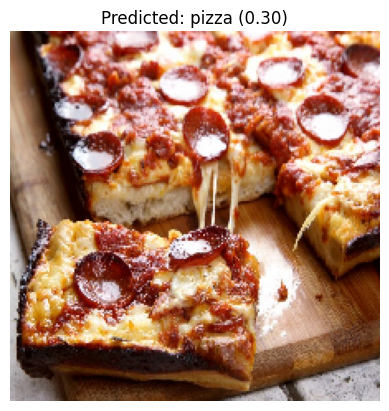

In [ ]:
predict_and_show('data/pizza/048.jpg')



In [ ]:
healthy_map = {
    'idli': 'Healthy',
    'dal_makhani': 'Healthy',
    'chapati': 'Healthy',
    'burger': 'Unhealthy',
    'pizza': 'Unhealthy',
    'samosa': 'Unhealthy',
    'chai': 'Unhealthy',
    'kulfi': 'Unhealthy',
    'paani_puri': 'Unhealthy',
    'pakode': 'Unhealthy',
    'momos': 'Unhealthy',
    'kaathi_rolls': 'Unhealthy',
    'kadai_paneer': 'Healthy',
    'butter_naan': 'Unhealthy',
    'fried_rice': 'Unhealthy',
    'pav_bhaji': 'Unhealthy',
    'jalebi': 'Unhealthy',
    'chole_bhature': 'Unhealthy',
    'dhokla': 'Healthy',
    'masala_dosa': 'Healthy'
}


In [ ]:
def predict_and_show(img_path):
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    health_status = healthy_map.get(predicted_class, "Unknown")

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f})\nHealthiness: {health_status}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


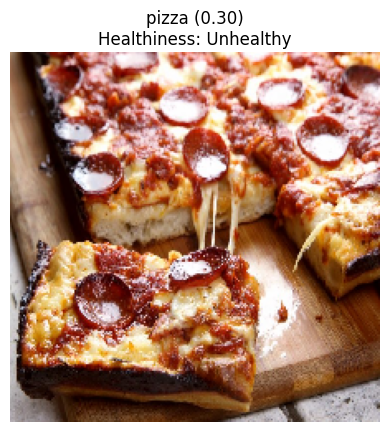

In [ ]:
predict_and_show('data/pizza/048.jpg')  # Replace with your actual image path


In [ ]:
import os

sample_images = os.listdir('data/idli')
print(sample_images)


['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '019.JPG', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '005.cms', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


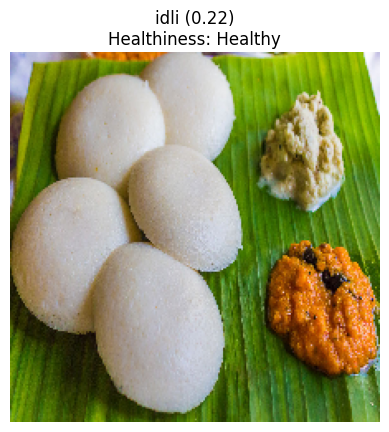

In [ ]:
predict_and_show('data/idli/114.jpg')

In [ ]:
class_names = train_dataset.class_names
print("Classes:", class_names)


Classes: ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']


In [ ]:
import os

sample_images = os.listdir('data/burger')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


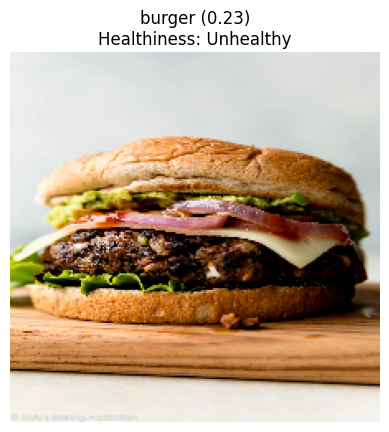

In [ ]:
predict_and_show('data/burger/104.jpg')

In [ ]:
import os

sample_images = os.listdir('data/butter_naan')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '324.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '024.JPG', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '328.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


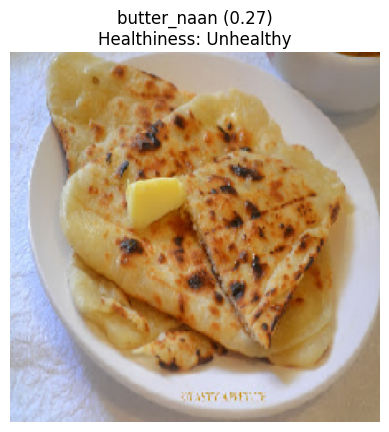

In [ ]:
predict_and_show('data/butter_naan/114.jpg')

In [ ]:
import os

sample_images = os.listdir('data/chai')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '375.jpg', '363.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '360.jpg', '369.jpg', '236.jpg', '283.jpg', '346.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '343.jpg', '348.jpg', '324.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '359.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '376.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '338.jpg', '147.jpg', '379.jpg', '284.jpg', '186.jpg', '373.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '350.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '328.jpg', '347.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '372.jpg', '054.jpg', '268.jpg', '187.jpg', '365.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '358.jpg', '090.jpg', '155.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


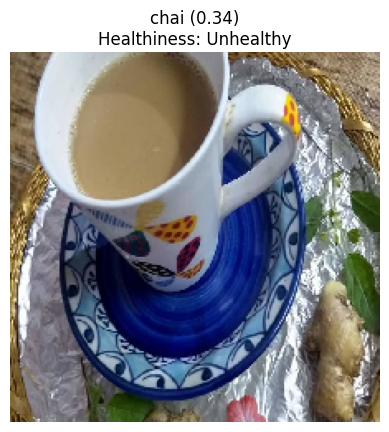

In [ ]:
predict_and_show('data/chai/369.jpg')

In [ ]:
import os

sample_images = os.listdir('data/chapati')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '375.jpg', '363.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '360.jpg', '369.jpg', '236.jpg', '283.jpg', '346.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '408.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '343.jpg', '348.jpg', '324.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '359.jpg', '079.jpg', '256.jpg', '042.jpg', '402.jpg', '388.jpg', '049.jpg', '249.jpg', '376.jpg', '405.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '411.jpg', '140.jpg', '222.jpg', '154.jpg', '338.jpg', '147.jpg', '407.jpg', '379.jpg', '406.jpg', '284.jpg', '186.jpg', '373.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '350.jpg', '384.jpg', '382.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '328.jpg', '347.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '372.jpg', '054.jpg', '268.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


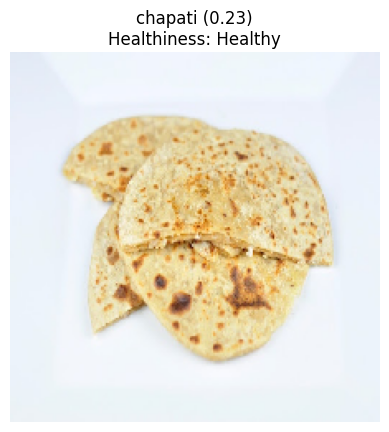

In [ ]:
predict_and_show('data/chapati/103.jpg')

In [ ]:
import os

sample_images = os.listdir('data/chole_bhature')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '375.jpg', '015.JPG', '363.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '360.jpg', '369.jpg', '236.jpg', '283.jpg', '346.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '408.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '343.jpg', '348.jpg', '324.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '359.jpg', '079.jpg', '256.jpg', '042.jpg', '402.jpg', '388.jpg', '049.jpg', '249.jpg', '376.jpg', '405.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '411.jpg', '140.jpg', '222.jpg', '154.jpg', '338.jpg', '147.jpg', '407.jpg', '379.jpg', '406.jpg', '284.jpg', '186.jpg', '373.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '350.jpg', '384.jpg', '382.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '328.jpg', '347.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '372.jpg', '054.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


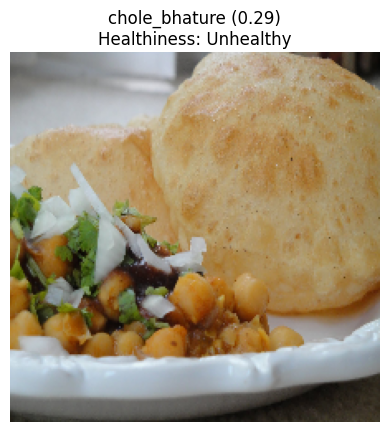

In [ ]:
predict_and_show('data/chole_bhature/015.JPG')

In [ ]:
import os

sample_images = os.listdir('data/dal_makhani')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


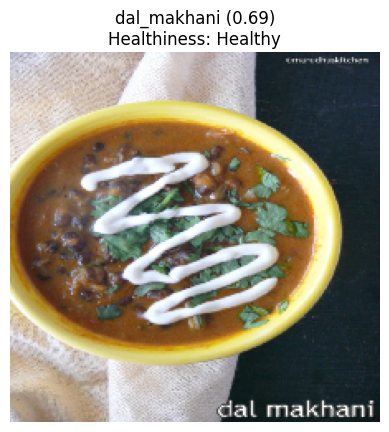

In [ ]:
predict_and_show('data/dal_makhani/321.jpg')

In [ ]:
import os

sample_images = os.listdir('data/dhokla')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


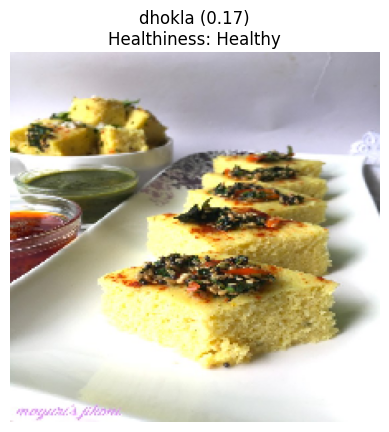

In [ ]:
predict_and_show('data/dhokla/283.jpg')

In [ ]:
import os

sample_images = os.listdir('data/fried_rice')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '346.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '343.jpg', '348.jpg', '324.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '338.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '350.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '328.jpg', '347.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '010.jpeg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '342.jpg

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


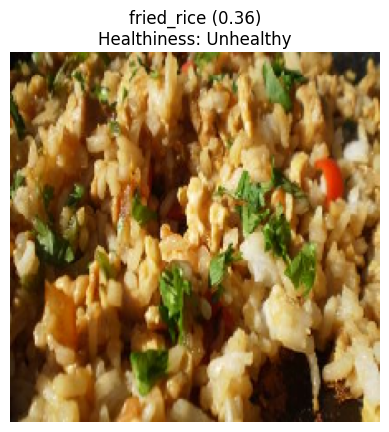

In [ ]:
predict_and_show('data/fried_rice/154.jpg')

In [ ]:
import os

sample_images = os.listdir('data/jalebi')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '028.JPG', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


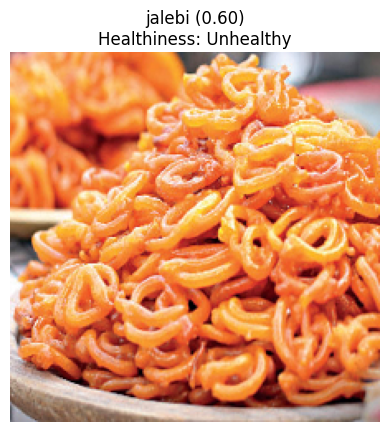

In [ ]:
predict_and_show('data/jalebi/284.jpg')

In [ ]:
import os

sample_images = os.listdir('data/samosa')
print(sample_images)


['104.jpg', '214.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg', '013.jpg', '001.jpg', '078.jpg', '076.jpg', '137.jpg', '166.jpg', '168.jpg', '224.jpg', '127.jpg', '178.jpg', '016.jpg', '243.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


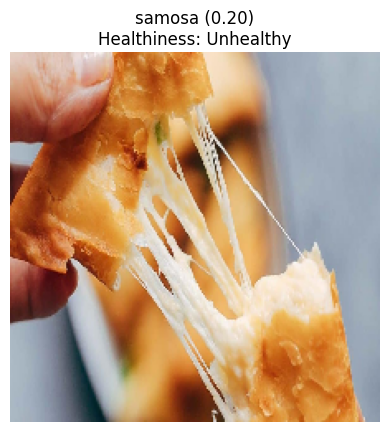

In [ ]:
predict_and_show('data/samosa/090.jpg')

In [ ]:
import os

sample_images = os.listdir('data/kaathi_rolls')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


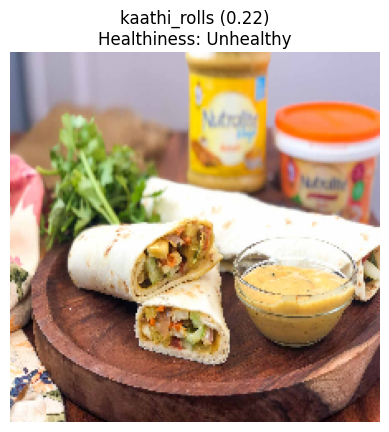

In [ ]:
predict_and_show('data/kaathi_rolls/030.jpg')

In [ ]:
import os

sample_images = os.listdir('data/kulfi')
print(sample_images)

['104.jpg', '214.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '170.jpg', '069.jpg', '079.jpg', '042.jpg', '049.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '072.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '106.jpg', '011.jpg', '054.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg', '013.jpg', '001.jpg', '078.jpg', '076.jpg', '137.jpg', '166.jpg', '168.jpg', '224.jpg', '127.jpg', '178.jpg', '231.jpg', '152.jpg', '125.jpg', '218.jpg', '081.jpg', '157.jpg', '173.jpg', '007.cms'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


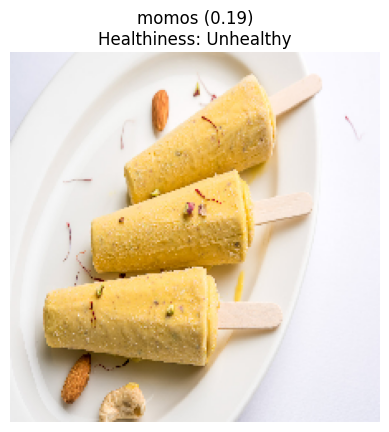

In [ ]:
predict_and_show('data/kulfi/003.jpg')

In [ ]:
import os

sample_images = os.listdir('data/masala_dosa')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


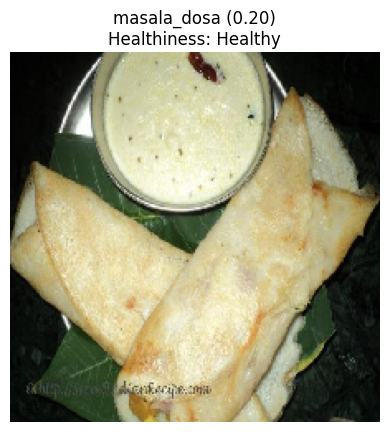

In [ ]:
predict_and_show('data/masala_dosa/116.jpg')

In [ ]:
import os

sample_images = os.listdir('data/momos')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '288.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


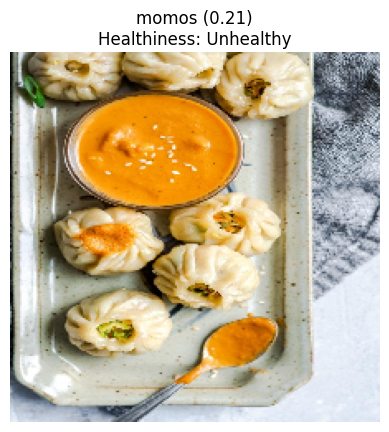

In [ ]:
predict_and_show('data/momos/046.jpg')

In [ ]:
import os

sample_images = os.listdir('data/paani_puri')
print(sample_images)

['104.jpg', '114.jpg', '027.jpg', '116.jpg', '046.jpg', '070.jpg', '043.jpg', '103.jpg', '071.jpg', '069.jpg', '079.jpg', '042.jpg', '049.jpg', '036.jpg', '101.jpg', '072.jpg', '067.jpg', '039.jpg', '120.jpg', '020.jpg', '066.jpg', '053.jpg', '113.jpg', '099.jpg', '106.jpg', '011.jpg', '054.jpg', '122.jpg', '090.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '082.jpg', '033.jpg', '105.jpg', '089.jpg', '022.jpg', '092.jpg', '013.jpg', '001.jpg', '078.jpg', '076.jpg', '127.jpg', '016.jpg', '125.jpg', '081.jpg', '075.jpg', '062.jpg', '048.jpg', '129.jpg', '038.jpg', '094.jpg', '044.jpg', '032.jpg', '021.jpg', '126.jpg', '002.jpg', '077.jpg', '097.jpg', '086.jpg', '019.jpg', '115.jpg', '052.jpg', '100.jpg', '123.jpg', '063.jpg', '059.jpg', '057.jpg', '085.jpg', '065.jpg', '108.jpg', '040.jpg', '060.jpg', '083.jpg', '050.jpg', '026.jpg', '009.jpg', '128.jpg', '037.jpg', '025.jpg', '061.jpg', '003.jpg', '121.jpg', '058.jpg', '031.jpg', '056.jpg', '051.jpg', '035.jpg', '107.jpg', '015.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


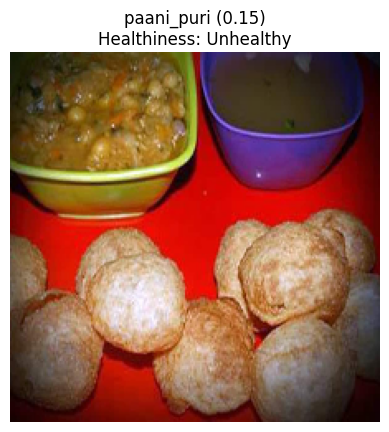

In [ ]:
predict_and_show('data/paani_puri/061.jpg')

In [ ]:
import os

sample_images = os.listdir('data/pakode')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '071.jpg', '177.jpg', '212.jpg', '262.jpg', '170.jpg', '069.jpg', '273.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '147.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '033.jpg', '181.jpg', '105.jpg', '089.jpg', '159.jpg', '190.jpg', '022.jpg', '195.jpg', '232.jpg', '092.jpg', '207.jpg', '138.jpg', '013.jpg', '001.jpg', '078.jpg', '076.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


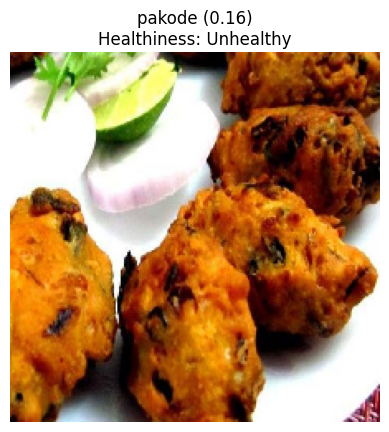

In [ ]:
predict_and_show('data/pakode/275.jpg')

In [ ]:
import os

sample_images = os.listdir('data/pav_bhaji')
print(sample_images)

['277.jpg', '104.jpg', '272.jpg', '214.jpg', '275.jpg', '114.jpg', '027.jpg', '188.jpg', '116.jpg', '236.jpg', '283.jpg', '346.jpg', '174.jpg', '046.jpg', '070.jpg', '146.jpg', '220.jpg', '043.jpg', '103.jpg', '319.jpg', '071.jpg', '177.jpg', '343.jpg', '348.jpg', '324.jpg', '212.jpg', '262.jpg', '320.jpg', '170.jpg', '069.jpg', '273.jpg', '321.jpg', '079.jpg', '256.jpg', '042.jpg', '049.jpg', '249.jpg', '269.jpg', '036.jpg', '206.jpg', '234.jpg', '101.jpg', '239.jpg', '282.jpg', '072.jpg', '238.jpg', '067.jpg', '140.jpg', '222.jpg', '154.jpg', '338.jpg', '147.jpg', '284.jpg', '186.jpg', '039.jpg', '120.jpg', '184.jpg', '270.jpg', '350.jpg', '267.jpg', '020.jpg', '066.jpg', '053.jpg', '225.jpg', '113.jpg', '328.jpg', '347.jpg', '099.jpg', '242.jpg', '106.jpg', '011.jpg', '054.jpg', '268.jpg', '187.jpg', '217.jpg', '200.jpg', '122.jpg', '145.jpg', '090.jpg', '155.jpg', '172.jpg', '055.jpg', '064.jpg', '087.jpg', '030.jpg', '196.jpg', '201.jpg', '082.jpg', '167.jpg', '342.jpg', '033.jpg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


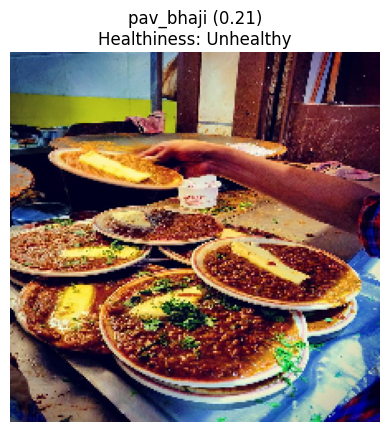

In [ ]:
predict_and_show('data/pav_bhaji/114.jpg')

In [ ]:
model.save("indian_food_classifier.h5")


In [ ]:
from google.colab import files
files.download("indian_food_classifier.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>